In [51]:
import os
import sys
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal #for signal processing
import scipy.stats as stats

os.chdir("/Users/etmu9498/research/code/scripts-winter2023/")
import helper_fns_winter2023
sys.path.append(  "/Users/etmu9498/research/code/scripts-winter2023/cloud-top-height-stats")
import eyewall_metadata
import find_cloud_tops
import cloud_top_plotting


In [108]:
# choose which data subset to look at
tc = 'all'
eye_limits='default'
crl_root_path = "/Users/etmu9498/research/data/crl-all-data-processed/"

# recursively save dates, cloud heights, and power outputs to lists here!
dates, passes, cloudheights, heightaxes, powers = [], [], [], [], []

# use a helper fn to get the relevant years and files
yearlist, filelist = helper_fns_winter2023.get_crl_datasets( tc=tc)

# print out the number of files to be used
filecount = 0
for yeari in range( len( filelist)):
    # count all the names in this year, and add to the count
    filecount += len( filelist[ yeari])
print("Number of data files to be used in analysis: " + str( filecount))

# load eyewall limits from helper function
metadata = eyewall_metadata.all_metadata( eye_limits=eye_limits)

# do this for all the datasets! years and filenames
for yeari, yearval in enumerate( yearlist):
    print( "Year: " + yearval)
    for filei, fileval in enumerate( filelist[ yeari]):
        print( "File: " + fileval)

        # grab the limits for this case
        # simplified filename
        date = fileval[7:11]
        # check if this date exists... if not, give it some empty eyewall limits!
        # also account for fred am and pm cases!!
        if date == '0812':
            if fileval[11:13] == "H1":
                eyewall_limits = metadata[ yearval]['eyewall_limits'][ '0812am']
            elif fileval[11:13] == "H2":
                eyewall_limits = metadata[ yearval]['eyewall_limits'][ '0812pm']
        elif date in metadata[ yearval]['eyewall_limits'].keys():
            eyewall_limits = metadata[ yearval]['eyewall_limits'][ date]
        else:
            eyewall_limits = [ ()]
            
            
        # do this for each of the eyewall limit pairs! Can have multiple eyes per crl dataset
        for eyei, eyeval in enumerate( eyewall_limits):
            # load crl data
            os.chdir( crl_root_path + yearval)
            crl_data = xr.open_dataset( fileval)

            if len( eyeval) > 0:

                # find the corresponding indices to the time limits
                ind0 = np.argmin( np.abs(crl_data.time.values - eyeval[0] ))
                ind1 = np.argmin( np.abs(crl_data.time.values - eyeval[1] ))

                # clip relevant fields down to the eyewall limits
                H = crl_data.height
                power = crl_data.P_ch1[ ind0 : ind1, :]
                axis = crl_data.time[ ind0 : ind1]
                p3_height = crl_data.p3_height[ ind0 : ind1]

                #print( "h: " + str( len( H)))
                #print( "power: " + str( np.shape( power)))
                #print( 't: ' + str( len( axis)))

                # find cloud top heights for values within the specified eye distance range
                if yearval == '2021':
                    cutoff = -30
                elif yearval == '2022':
                    cutoff = -40
                heights, time = find_cloud_tops.find_cloud_heights( H, power, axis, p3_height, cutoff_power = cutoff)
                
                cloudheights.append(heights)
                dates.append(date)
                passes.append(eyei)
                powers.append(power)
                heightaxes.append(H.values)
                
                print("heights found")


Number of data files to be used in analysis: 35
Year: 2021
File: P3_20210811H1_processed.nc
File: P3_20210812H1_processed.nc
heights found
heights found
heights found
File: P3_20210812H2_processed.nc
heights found
heights found
File: P3_20210813H1_processed.nc
heights found
heights found
File: P3_20210816H1_processed.nc
heights found
heights found
File: P3_20210817H1_processed.nc
heights found
heights found
heights found
File: P3_20210818H1_processed.nc
heights found
heights found
heights found
File: P3_20210819H1_processed.nc
heights found
heights found
heights found
File: P3_20210820H1_processed.nc
heights found
heights found
File: P3_20210821H2_processed.nc
heights found
heights found
heights found
File: P3_20210827H1_processed.nc
heights found
heights found
heights found
heights found
File: P3_20210828H1_processed.nc
heights found
File: P3_20210829H1_processed.nc
heights found
File: P3_20210925H1_processed.nc
File: P3_20210926H1_processed.nc
heights found
heights found
heights foun

In [109]:
print(len(dates))
print(len(powers))
print(dates)

# for power in powers:
#     print(np.shape(power))

print(np.shape(powers[0]))
print(np.shape(powers[1]))

print(np.shape( np.concatenate( (powers[0], powers[1]), axis=0)))

86
86
['0812', '0812', '0812', '0812', '0812', '0813', '0813', '0816', '0816', '0817', '0817', '0817', '0818', '0818', '0818', '0819', '0819', '0819', '0820', '0820', '0821', '0821', '0821', '0827', '0827', '0827', '0827', '0828', '0829', '0926', '0926', '0926', '0927', '0927', '0929', '0929', '0901', '0901', '0901', '0903', '0903', '0903', '0903', '0904', '0905', '0905', '0905', '0905', '0906', '0906', '0906', '0908', '0908', '0908', '0916', '0916', '0916', '0917', '0917', '0918', '0918', '0918', '0918', '0918', '0920', '0920', '0920', '0920', '0924', '0924', '0924', '0925', '0925', '0926', '0926', '0926', '0926', '0927', '0927', '0927', '1007', '1007', '1007', '1008', '1008', '1008']
(343, 667)
(218, 667)
(561, 667)


<class 'numpy.ndarray'>


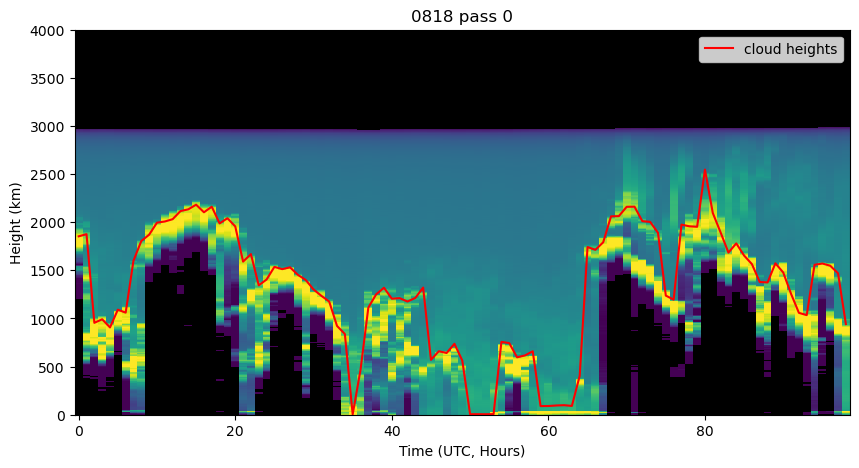

In [110]:
# test plot
i = 12
power = powers[i]

print(type(power.values))

H = heightaxes[i]
axis = np.arange( np.shape( power)[0])

plt.figure( figsize=(10, 5))
plt.title( dates[i] + " pass " + str( passes[i]))
min = -30
max = -10
plt.pcolormesh( axis, H, power.transpose(), vmin = min, vmax = max)
plt.plot( axis, cloudheights[i], c='r', label='cloud heights')
plt.legend()
plt.xlabel( 'Time (UTC, Hours)')
plt.ylabel( "Height (km)")
plt.ylim( [0, np.nanmax( H)])
ax = plt.gca()
ax.set_facecolor('k')


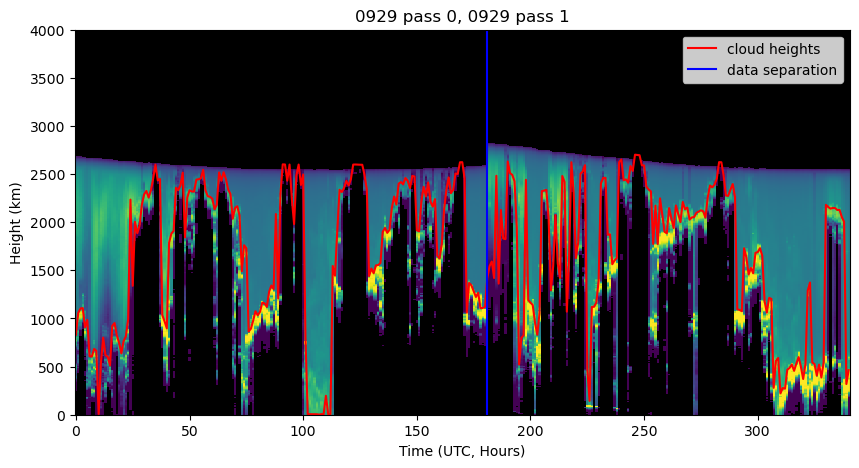

In [111]:
# plot two eyes concatenated together
i, j = 34, 35
power = np.concatenate( (powers[i], powers[j]), axis=0)
H = heightaxes[i]
axis = np.arange( np.shape( power)[0])
hts = np.concatenate( (cloudheights[i], cloudheights[j]), axis=0)

plt.figure( figsize=(10, 5))
plt.title( dates[i] + " pass " + str( passes[i]) + ', ' + dates[j] + " pass " + str( passes[j]))
min = -30
max = -10
plt.pcolormesh( axis, H, power.transpose(), vmin = min, vmax = max)
plt.plot( axis, hts, c='r', label='cloud heights')

plt.axvline(x=len(cloudheights[i]), c='b', label='data separation')

plt.legend()
plt.xlabel( 'Time (UTC, Hours)')
plt.ylabel( "Height (km)")
plt.ylim( [0, np.nanmax( H)])
ax = plt.gca()
ax.set_facecolor('k')


In [117]:
# concatenate and plot all cloud heights together!
allheights = np.array([])
for chi, chval in enumerate(cloudheights):
    allheights = np.concatenate( (allheights, chval), axis=0)
print(type(allheights))
print(np.shape(allheights))
print(len(allheights))

print(len(np.where(np.isnan(allheights))[0]))
print(np.where(np.isnan(allheights))[0])

<class 'numpy.ndarray'>
(11997,)
11997
0
[]


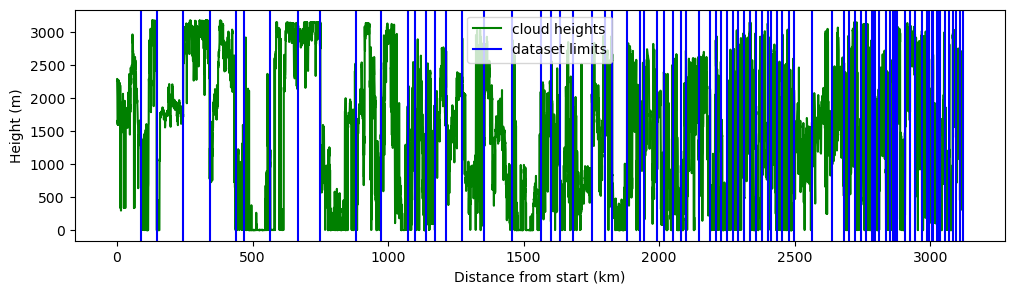

In [144]:
# make a fake distance axis, do crl timestep (2s) * p3 flight speed (130m/s)
# or, just use the default axis do 2 * instead
scaling = 260 / 1000
if scaling == .26:
    xlabel = "Distance from start (km)"
    freqlabel = 'Frequency (km^-1)'
    xlims, ylims = [.0001, .4], [0, .4] # [0, .01]
elif scaling == 2:
    xlabel = "Time Since Start (s)"
    freqlabel = 'Frequency (Hz)'
    xlims, ylims = [.0001, .2], [0, .4] # [0, .01]

window_length = 240 # settings
T2 = window_length / 2
freq_w = ( np.arange(0., T2 + 1.) / window_length ) / scaling 

dists = np.arange(len(allheights)) * scaling

plt.figure(figsize=(12, 3))
plt.plot(dists, allheights, c='g', label='cloud heights')

# make a list of 
sumcount = 0
linelocations = []
for val in cloudheights:
    sumcount += len(val)
    linelocations.append(sumcount)
linelocations = np.array(linelocations) * scaling

for i, val in enumerate(linelocations):
    if i == 0:
        plt.axvline(x=val, c='b', label='dataset limits')
    else:
        plt.axvline(x=val, c='b')

# plt.xlabel("Total Distance, All Eyes (km)")
plt.xlabel(xlabel)
plt.ylabel("Height (m)")
plt.legend()

In [145]:
print("frequency = .01 Hz -> " + str(np.round(1/.01, 3)) + " seconds, " + str(np.round((1/.01)*260, 3)) + " m")
print("frequency = .05 Hz -> " + str(np.round(1/.05, 3)) + " seconds, " + " seconds, " + str(np.round((1/.05)*260, 3)) + " m")
print("frequency = .1 Hz -> " + str(np.round(1/.1, 3)) + " seconds, " + " seconds, " + str(np.round((1/.1)*260, 3)) + " m")

frequency = .01 Hz -> 100.0 seconds, 26000.0 m
frequency = .05 Hz -> 20.0 seconds,  seconds, 5200.0 m
frequency = .1 Hz -> 10.0 seconds,  seconds, 2600.0 m


In [146]:
# helper fns

# get the power spectrum of red noise for this dataset
def create_normalized_redfit(data_length,Te):
    freq = np.arange(0,(data_length/2)+1,1)/float(data_length) # to Nyquist
    red_fit = (2 * Te)/(1 + ((2*np.pi*freq)**2)*(Te**2)) # After Hartmann 6.64, 6.91
    return red_fit/np.sum(red_fit)

# using the red noise power spectrum and a given confidence level, calculate the confidence limits for each data point
def create_f_bounds(alpha,dof,red_fit_n):
    f_ratio = stats.f.ppf(alpha,dof,200) # Note: 200 = large degree of freedom for red noise
    return f_ratio*red_fit_n

### Function to make window for Lanczos Filter
def low_pass_weights(window, cutoff):
    """Calculate weights for a low pass Lanczos filter.
    Args:
    window: int
        The length of the filter window in time steps
    cutoff: float
        The cutoff frequency in inverse time steps. 
        (e.g., for data collected every hour, frequency units are per hour)
    """
    order = ((window - 1) // 2 ) + 1
    nwts = 2 * order + 1
    w = np.zeros([nwts])
    n = nwts // 2
    w[n] = 2 * cutoff
    k = np.arange(1., n)
    sigma = np.sin(np.pi * k / n) * n / (np.pi * k)
    firstfactor = np.sin(2. * np.pi * cutoff * k) / (np.pi * k) 
    w[n-1:0:-1] = firstfactor * sigma
    w[n+1:-1] = firstfactor * sigma    
    return w[1:-1]


In [147]:
## Calculate the power spectrum of red noise with lag1_r to use for significance testing
# do this for non-smoothed data
alpha = 0.95 ## set statistical significance level

data = allheights.copy() # temp, wv
label = 'Cloud Heights'

### step 1: calculate lag-1 autocorrelation (lag1_r, rho) and the associated p value (lag1_p)
lag1_r,lag1_p = stats.pearsonr(data[0:len(data)-1],data[1:len(data)])
### step 2: Calculate e-folding time for a red-noise process with this lag-1 autocorrelation
Te = -1./np.log(lag1_r) # After Hartman 6.62 with delta t = 1
print('lag-1 autocorrelation =',round(lag1_r,2),'and Te =',round(Te,0))


lag-1 autocorrelation = 0.9 and Te = 10.0


frequency cutoff (per timestep): 0.05
121
DOF = 99.975


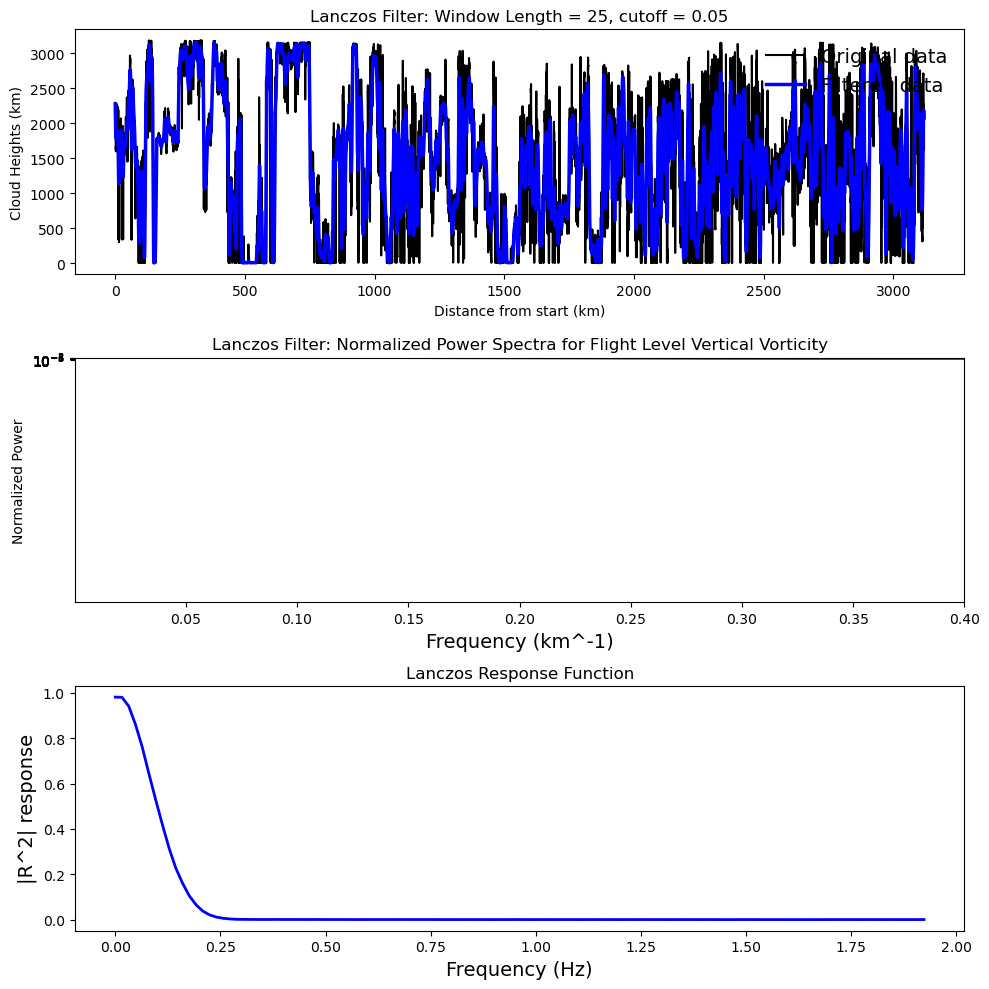

In [148]:
# find any frequencies in time series data!

## Calculate the power spectrum of red noise with lag1_r to use for significance testing
wtype = 'hamming'
normalize=True

# use the data scaling to set the frequency spacing!
P_welch = signal.welch( data, window=wtype, nperseg=window_length);
P_welch_n = P_welch[1] / np.sum(P_welch[1])  #normalize

# specify the window length for filters
window = 25 ## (default 25) 
cutoff = .05 ## (default 1./11.)
wgts24 = low_pass_weights(window, cutoff) # find lanczos filter weights
y2 = signal.filtfilt(wgts24, np.sum(wgts24), allheights) # filter the data!

# print('oscillation frequency synthetic data (per timestep): '+str(freq_w))
print('frequency cutoff (per timestep): '+str(cutoff))


# make a figure for this case!

# calculate the power spectrum
P_welch_filt = signal.welch( y2, window='hamming', nperseg = window_length);
P_welch_n_filt = P_welch_filt[1]/np.sum(P_welch_filt[1])  #normalize
### Calculate the response function of the boxcar filter using the convolution theorem
R2_bw=P_welch_filt[1]/P_welch[1]


## Construct the expected rednoise spectrum - functions
## Need to update the 99% confidence interval - we have more DOF
red_fit_n_welch = create_normalized_redfit(window_length,Te)  ## generate red_fit_n using window_length
print(np.size(red_fit_n_welch))
dof_welch=len(data) / (window_length / 2)  ### Barnes Eq. 59, factor fw=1 here (based on HW 4 instructions)
print('DOF =', dof_welch)
f_bounds_welch = create_f_bounds(alpha, dof_welch, red_fit_n_welch)  ## f-test for variance; 



## plot the results of the boxcar filtering!
fig = plt.figure(figsize=(10,10))

plt.subplot(311)
plt.plot(dists, data, 'k', linewidth = 1.5, label = 'Original data')
plt.plot(dists, y2, 'b', linewidth = 2.5, label = 'Filtered data')
plt.title('Lanczos Filter: Window Length = '+str( window) + ', cutoff = ' + str(cutoff))
plt.legend(frameon = False,fontsize = 14,loc='upper right')
plt.xlabel(xlabel)
plt.ylabel("Cloud Heights (km)")

plt.subplot(312)
plt.title("Lanczos Filter: Normalized Power Spectra for Flight Level Vertical Vorticity") 
plt.xlabel(freqlabel,fontsize=14)
if normalize:
    plt.plot(freq_w, P_welch_n, color='k', lw=1.3, label='Original Spectra')
    plt.plot(freq_w, P_welch_n_filt, color='b', lw=1.3, label='Filtered Spectra')
    plt.ylabel('Normalized Power')
    plt.plot(freq_w,red_fit_n_welch, color='firebrick', lw=1, alpha=0.9, label='Red Noise Fit')
    plt.plot(freq_w,f_bounds_welch, color='firebrick', lw=1, ls='--', alpha=0.9, label=str(int(alpha*100))+'% CI')
else:
    plt.plot(freq_w, P_welch[1], color='k', lw=1.3, label='Original Spectra')
    plt.plot(freq_w, P_welch_filt[1], color='b', lw=1.3, label='Filtered Spectra')
    plt.ylabel('Total Power')
plt.ylim(ylims)
plt.xlim(xlims)
plt.yscale('log')

    
# plt.axvline(x=.03)

# plot the response function!!
plt.subplot(313)
plt.title("Lanczos Response Function")
plt.plot(freq_w, R2_bw,'-b',linewidth = 2, label = 'Boxcar N = '+str(window))
plt.xlabel('Frequency (Hz)',fontsize=14)
plt.ylabel('|R^2| response',fontsize=14)
fig.tight_layout()
